# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***


### Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import statistics
import cv2
import os
import glob
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Class Data Type

In [2]:
# Define a class to receive the characteristics of each line detection
#This is useful for debugging as well as comparing current frame data fits to previous fits.
class Line():
    def __init__(self):
        #choosing a number of iterations
        self.n = 20
        # was the line detected in the last iteration?
        self.detected = False  
        # x values for the best-fit lines
        self.recent_xfitted = [] 
        #average x value of the best-fit lines over the last n iterations
        self.bestx = None     
        #polynomial coefficients for the best-fit line
        self.recent_fit = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [0,0,0]#None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
    def add_recent_xfitted(self,new_recent_xfitted):
        #record the newest x points
        self.recent_xfitted.append(new_recent_xfitted)
        size = len(self.recent_xfitted)
        last_n_xfitted_means = []
        if ((size-self.n)<0): #account for there being less than n images so far
            num = size
        else:
            num = self.n
        #fill the array 'last_n_fitted_means' with the mean x value of the line in each image
        for fit in range((size-num),(size)):
            if self.recent_xfitted[fit][0] != 0:
                last_n_xfitted_means.append(int(statistics.mean(self.recent_xfitted[fit])))
        #find the median of the last n images' mean x values
        self.bestx = (int(statistics.median(last_n_xfitted_means)))
        
        
    def add_recent_fit(self,new_recent_fit):
        #record the newest polynomial coefficients
        self.recent_fit.append(new_recent_fit)
        size = len(self.recent_fit)
        coeffA = []
        coeffB = []
        coeffC = []
        if ((size-self.n)<0): #account for there being less than n images so far
            num = size
        else:
            num = self.n
        #fill arrays with the last n polynomial coefficients
        for fit in range((size-num),(size)):
            if ((self.recent_fit[fit][0]!=0) and (self.recent_fit[fit][1]!=0) and (self.recent_fit[fit][2]!=0)):
                coeffA.append(self.recent_fit[fit][0])
                coeffB.append(self.recent_fit[fit][1])
                coeffC.append(self.recent_fit[fit][2])
        #find the median of the last n polynomial coefficients
        self.best_fit[0]=statistics.median(coeffA)
        self.best_fit[1]=statistics.median(coeffB)
        self.best_fit[2]=statistics.median(coeffC)
        #find the difference between the newest polynomial coefficients and those of the previous image        
        self.diffs[0] = abs(new_recent_fit[0]-self.recent_fit[size-2][0])
        self.diffs[1] = abs(new_recent_fit[1]-self.recent_fit[size-2][1])
        self.diffs[2] = abs(new_recent_fit[2]-self.recent_fit[size-2][2])

In [3]:
leftStats = Line()
rightStats = Line()

### Global Variables

In [4]:
#Determine the image size using one image example.
#this assumes the first two dimensions of all images taken with this camera are the same size
exSize = cv2.imread('camera_cal/calibration1.jpg')
img_size = (exSize.shape[1], exSize.shape[0]) # (x,y) = (1280,720) in this example

# Define conversions in x and y from pixels space to meters
#the lane lines in the top-down image have length 720 pixels (height of the image)
#assume this represents approximately the 25 meters of lane lines in front of the car
ym_per_pix = 30/720 # meters per pixel in y dimension
#there are about 662 pixels between the centers of the left lane line and right lane line
#assume real world distance between the lane lines is 3.7 meters
xm_per_pix = 3.7/662 # meters per pixel in x dimension

### Basic Functions

In [5]:
def undistort(img): #uses the camera calibration to undistort the image
    return cv2.undistort(img, mtx, dist, None, mtx) #mtx and dist are global variables defined during calibration
    
def perspectiveTrans(img): #performs a transformation on the image to get a top-down view
    return cv2.warpPerspective(img, M, img_size) 
        
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.): #overlays two images
    return cv2.addWeighted(initial_img, α, img, β, γ) 

### Elaborate Functions
***

This cell returns a binary image showing the yellow and white pixels

In [22]:
def pull_Yellow_White(img): #returns a binary image showing the yellow and white pixels
    hsv_image=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

    yellow_lower = np.array([15, 70, 70])
    yellow_upper = np.array([40, 255, 255])
    yellow = cv2.inRange(hsv_image, yellow_lower, yellow_upper)

    white_lower = np.array([0,0,180])
    white_upper = np.array([255,30,255])
    white = cv2.inRange(hsv_image, white_lower, white_upper)

    yellowWhite = weighted_img(white,yellow)
    
    return yellowWhite

This cell uses a histogram tool to find points representing the lane lines

In [7]:
def find_lane_pixels(binary_warped):
    global ftype
    global frameNum
    global leftStats
    global rightStats
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If it found > minpix pixels, recenter next window (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

To save time, if the previous frame of a video successfully found valid lines, then just search near those lines on the current frame, rather than blindly searching again.

In [8]:
def search_around_poly(binary_warped):
    global leftStats
    global rightStats
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #instead of searching the entire image for pixels, search just around the previous best-fit lines
    sizeL = len(leftStats.recent_fit)
    sizeR = len(rightStats.recent_fit)
    
    left_lane_inds = ((nonzerox > (leftStats.recent_fit[sizeL-1][0]*(nonzeroy**2) + leftStats.recent_fit[sizeL-1][1]*nonzeroy + 
                    leftStats.recent_fit[sizeL-1][2] - margin)) & (nonzerox < (leftStats.recent_fit[sizeL-1][0]*(nonzeroy**2) + 
                    leftStats.recent_fit[sizeL-1][1]*nonzeroy + leftStats.recent_fit[sizeL-1][2] + margin)))
    right_lane_inds = ((nonzerox > (rightStats.recent_fit[sizeR-1][0]*(nonzeroy**2) + rightStats.recent_fit[sizeR-1][1]*nonzeroy + 
                    rightStats.recent_fit[sizeR-1][2] - margin)) & (nonzerox < (rightStats.recent_fit[sizeR-1][0]*(nonzeroy**2) + 
                    rightStats.recent_fit[sizeR-1][1]*nonzeroy + rightStats.recent_fit[sizeR-1][2] + margin)))
    
    #extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    return leftx, lefty, rightx, righty, out_img

This cell fits a polynomial equation to the points determined, highlights the pixels of each lane line, and returns that image along with coordinates of the two best-fit lines

In [9]:
def fit_polynomial(binary_warped):
    global ftype
    global frameNum
    global leftStats
    global rightStats
    # Find our lane pixels first
    #if the previous frame of a video contained well-detected lines, then save time by just searching near
    #the location of those lines, otherwise do a full search from scratch
    if ((leftStats.detected == True) and (rightStats.detected == True) and (ftype == 'Video')):
        leftx, lefty, rightx, righty, out_img = search_around_poly(binary_warped)
    else:
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)  
    
    #Fit a second order polynomial to each lane line.
    #lefty is first, then leftx. To avoid a straight line with infinite slope, righty is the independent variable
    #if find_lane_pixels() failed to find pixels, then just use coefficients from previous data
    try:
        left_fit = (np.polyfit(lefty,leftx,2)) 
        leftStats.detected = True
    except TypeError:
        #avoids error if no data points
        if (ftype == 'Image'):
            print('The function failed to find valid left line coordinates')
        if (ftype == 'Video'):
            print('The function failed to find valid left line coordinates, making substitution')
            left_fit = leftStats.best_fit #use average of previous values
            leftStats.detected = False
          
    if ((ftype == 'Video') and (frameNum > leftStats.n) and (leftStats.detected == True)):
        numFitL=len(leftStats.recent_fit)
        if ((abs(leftStats.recent_fit[numFitL-1][0]-left_fit[0])> (0.0005*4)) or (abs(leftStats.recent_fit[numFitL-1][1]-left_fit[1])> (0.5*4)) or (abs(leftStats.recent_fit[numFitL-1][2]-left_fit[2])>(40*4))):
            leftStats.detected = False
            left_fit=((leftStats.best_fit+leftStats.recent_fit[numFitL-1])/2)
        elif ((abs(leftStats.recent_fit[numFitL-1][0]-left_fit[0])> (0.0005)) or (abs(leftStats.recent_fit[numFitL-1][1]-left_fit[1])> (0.5)) or (abs(leftStats.recent_fit[numFitL-1][2]-left_fit[2])>(40))):
            leftStats.detected = True
            left_fit[0] = (leftStats.best_fit[0]*2+left_fit[0])/3 #if out of range, replace with average coefficients of recent frames
            left_fit[1] = (leftStats.best_fit[1]*2+left_fit[1])/3
            left_fit[2] = (leftStats.best_fit[2]*2+left_fit[2])/3
    
    try:
        right_fit = (np.polyfit(righty,rightx,2)) 
        rightStats.detected = True
    except TypeError:
        #avoids error if no data points
        if (ftype == 'Image'):
            print('The function failed to find valid right line coordinates')
        if (ftype == 'Video'):
            print('The function failed to find valid right line coordinates, making substitution')
            right_fit = rightStats.best_fit #use average of previous values
            rightStats.detected = False
          
    if ((ftype == 'Video') and (frameNum > rightStats.n) and (rightStats.detected == True)):        
        numFitR=len(rightStats.recent_fit)
        if ((abs(rightStats.recent_fit[numFitR-1][0]-right_fit[0])> (0.0005*4)) or (abs(rightStats.recent_fit[numFitR-1][1]-right_fit[1])> (0.5*4)) or (abs(rightStats.recent_fit[numFitR-1][2]-right_fit[2])>(40*4))):
            rightStats.detected = False
            right_fit=((rightStats.best_fit+rightStats.recent_fit[numFitR-1])/2)
        elif ((abs(rightStats.recent_fit[numFitR-1][0]-right_fit[0])> (0.0005)) or (abs(rightStats.recent_fit[numFitR-1][1]-right_fit[1])> (0.5)) or (abs(rightStats.recent_fit[numFitR-1][2]-right_fit[2])>(40))):
            rightStats.detected = True
            right_fit[0] = (rightStats.best_fit[0]*1+right_fit[0])/2 #if out of range, replace with average coefficients of recent frames
            right_fit[1] = (rightStats.best_fit[1]*1+right_fit[1])/2
            right_fit[2] = (rightStats.best_fit[2]*1+right_fit[2])/2
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit

This cell fits a polynomial, scaled in units of meters

In [10]:
def fit_polynomial_scaled(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)  
    
    #Fit a second order polynomial to each lane line.
    #lefty is first, then leftx. To avoid a straight line with infinite slope, righty is the independent variable
    left_fit_scaled = (np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)) 
    right_fit_scaled = (np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)) 
    
    return left_fit_scaled, right_fit_scaled

This is the routine used for videos

In [11]:
def process_image(image):
    global leftStats
    global rightStats
    global ftype
    #convert to RGB color space
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #correct for camera distortion
    undist = undistort(image)
    #get top-down view of lane lines
    perspTrans = perspectiveTrans(undist)
    #get binary image of lane lines
    binaryPersp = pull_Yellow_White(perspTrans)
    #fit a polynomial of best fit to each lane line
    polyLines, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(binaryPersp)
    #draw those polynomial equations on the image
    justLines = np.zeros_like(perspTrans)
    for pnt in range(0,ploty.size):
        justLines[int(ploty[pnt]),(int(left_fitx[pnt])-20) : (int(left_fitx[pnt])+20)]=[255,0,0]
        justLines[int(ploty[pnt]),(int(right_fitx[pnt])-20) : (int(right_fitx[pnt])+20)]=[0,0,255]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binaryPersp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    color_warp = weighted_img(justLines,color_warp)
    #create an inverse of the perspective transform matrix
    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[0], img_size[1])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #fit a polynomial of best fit to each lane line, scaled to meters
    if ((leftStats.detected == True) and (rightStats.detected == True) ):
        left_fit_scaled, right_fit_scaled = fit_polynomial_scaled(binaryPersp)
        # Define y-value where we want radius of curvature. The maximum y-value corresponds to the bottom of the image
        y_eval = np.max(ploty)  
        #Implement the calculation of R_curve (radius of curvature)
        left_curverad = ((1+(2*left_fit_scaled[0]*y_eval*ym_per_pix+left_fit_scaled[1])**2)**(3/2))/np.absolute(2*left_fit_scaled[0])
        right_curverad = ((1+(2*right_fit_scaled[0]*y_eval*ym_per_pix+right_fit_scaled[1])**2)**(3/2))/np.absolute(2*right_fit_scaled[0])
        #calculate the offset from center of lane
        xCenterOfCar = img_size[0]/2*xm_per_pix #assume camera is mounted at the centerline of the car
        xLeftLane = left_fit_scaled[0]*(y_eval*ym_per_pix)**2 + left_fit_scaled[1]*y_eval*ym_per_pix + left_fit_scaled[2]
        xRightLane = right_fit_scaled[0]*(y_eval*ym_per_pix)**2 + right_fit_scaled[1]*y_eval*ym_per_pix + right_fit_scaled[2]
        xCenterOfLane = (xRightLane - xLeftLane)/2 + xLeftLane
        laneOffset = xCenterOfCar - xCenterOfLane
    else: #if lane lines were not successfuly found, then use previous values
        if (leftStats.radius_of_curvature and rightStats.radius_of_curvature):
            left_curverad = leftStats.radius_of_curvature
            right_curverad = rightStats.radius_of_curvature
        else:
            left_curverad = 0
            right_curverad = 0
        if (leftStats.line_base_pos and rightStats.line_base_pos):
            laneOffset = leftStats.line_base_pos - rightStats.line_base_pos
        else:
            laneOffset = 0
        
    #display the curvature and offset on the image
    curveText = 'Curve Radius: Left Line {:.0f}m, Right Line {:.0f}m'.format(left_curverad,right_curverad)
    cv2.putText(result,curveText,(20,50),cv2.FONT_HERSHEY_SIMPLEX,1.3,[255,255,255],2,cv2.LINE_AA)
    offsetText = 'Car is {:.2f}m From Lane Center'.format(laneOffset)
    cv2.putText(result,offsetText,(20,100),cv2.FONT_HERSHEY_SIMPLEX,1.3,[255,255,255],2,cv2.LINE_AA)
    
    #save left line data
    if leftStats.detected == True:
        leftStats.add_recent_xfitted(left_fitx) #unscaled
        leftStats.add_recent_fit(left_fit)      #unscaled
        leftStats.radius_of_curvature = left_curverad #scaled
        if rightStats.detected == True:
            leftStats.line_base_pos = abs(xCenterOfCar-xLeftLane) #scaled   
        
    #save right lane line data    
    if rightStats.detected == True:
        rightStats.add_recent_xfitted(right_fitx) #unscaled
        rightStats.add_recent_fit(right_fit)      #unscaled
        rightStats.radius_of_curvature = right_curverad #scaled
        if leftStats.detected == True:
            rightStats.line_base_pos = abs(xRightLane-xCenterOfCar) #scaled

    #uncommend these lines to save individual images from the video for closer examination/debugging
    #saveName = 'test_videos_output/frame_{}.jpg'.format(frameNum)
    #cv2.imwrite(saveName,result)
    #cv2.imwrite(saveName,perspTrans) 
    
    global frameNum
    frameNum += 1
    result = cv2.cvtColor(result,cv2.COLOR_RGB2BGR)
    return result


### Camera Calibration
This only needs to be performed one time, then the settings can be re-used to process each image
We use a series of checkerboard images at different angles/distances and determine their actual corner locations and then pass these coordinates, along with ideal grid coordinates to openCV's calibrateCamera(), which provides the settings needed to undistort our images.
There are a few built-in checks to help ensure that this process is working. Once the checkerboard corners are found, they are drawn on a copy of the image and saved.  The image calibration1.jpg is then undistorted and a copy saved as well.  These new images can be viewed to check that the calibration steps are in fact working.

In [12]:
chessNumIntX = 9 #the chessboard used for calibration has 9 intersections in the X axis
chessNumIntY = 6 #and 6 intersections in the Y axis

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chessNumIntY*chessNumIntX,3), np.float32)
objp[:,:2] = np.mgrid[0:chessNumIntX, 0:chessNumIntY].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chessNumIntX,chessNumIntY), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners. This can be used as a check to see if the corners were properly found.
        cv2.drawChessboardCorners(img, (chessNumIntX,chessNumIntY), corners, ret)
        write_name = 'camera_cal_results/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        
        #cv2.imshow('img', img)  #uncomment these lines to show inline for convenience
        #cv2.waitKey(500)
        #cv2.destroyAllWindows()
        
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal_results/dist_pickle.p", "wb" ) )

#Read out the calibration settings. 
#This is somewhat redundant, but using these variables successfully later means they were correctly saved.
dist_pickle = pickle.load( open( "camera_cal_results/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

#undistort the test image and save a copy
#dst = cv2.undistort(img, mtx, dist, None, mtx)
dst = undistort(img)
cv2.imwrite('camera_cal_results/calibration1_undist.jpg',dst)

# Visualize undistortion: uncomment these lines to show inline for convenience
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#ax1.imshow(img)
#ax1.set_title('Original Image', fontsize=30)
#ax2.imshow(dst)
#ax2.set_title('Undistorted Image', fontsize=30)

True

### Determine the Region of Interest
The purpose of this cell is to visualize the area that will be perspective transformed into a bird's eye view.  It is useful during setup to identify appropriate coordinates of the area where the lane lines will be.

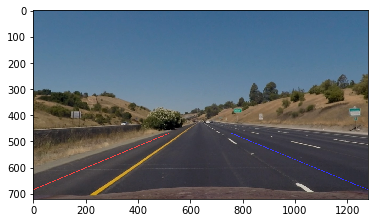

In [13]:
area_start_point_1 = (int(img_size[0]*0),int(img_size[1]*0.95))
area_end_point_1 = (int(img_size[0]*0.408), int(img_size[1]*0.65))
area_color1 = [0,0,255] #red
area_start_point_2 = (int(img_size[0]*1),int(img_size[1]*0.95))
area_end_point_2 = (int(img_size[0]*0.59), int(img_size[1]*0.65)) 
area_color2 = [255,0,0] #blue
thickness = 2
α=0.8
β=1
γ=0.
seeArea = cv2.imread('test_images/straight_lines1.jpg') #use an examle image to visualize the area
seeArea = undistort(seeArea) #undistort the image
seeLines = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
seeLines = cv2.line(seeLines, area_start_point_1, area_end_point_1, area_color1, thickness)
seeLines = cv2.line(seeLines, area_start_point_2, area_end_point_2, area_color2, thickness)
seeArea = cv2.addWeighted(seeArea,α, seeLines,β, γ)
cv2.imwrite('process_steps_pictures/region_of_interest.jpg',seeArea)
seeArea = cv2.cvtColor(seeArea, cv2.COLOR_BGR2RGB)
plt.imshow(seeArea)

### Determine Transformation Matrix
This cell determines the transformation matrix needed to obtain a top-down view of the lane lines

In [14]:
#define the region of the image where lane lines are presumed to be
src = np.float32([area_end_point_1, area_end_point_2, area_start_point_2, area_start_point_1])

#Choose a size for the resulting transformation
offset = 100
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])

#get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)

### Individual Steps in Process

This cell displays the results of the Perspective Transform to get a top-down view of the lane lines using an image in which the lane lines do not cuve.  Since the lane lines do not curve, the transformed image should appear to have two vertical lines if the transformation matrix (M) has been appropriately calculated.

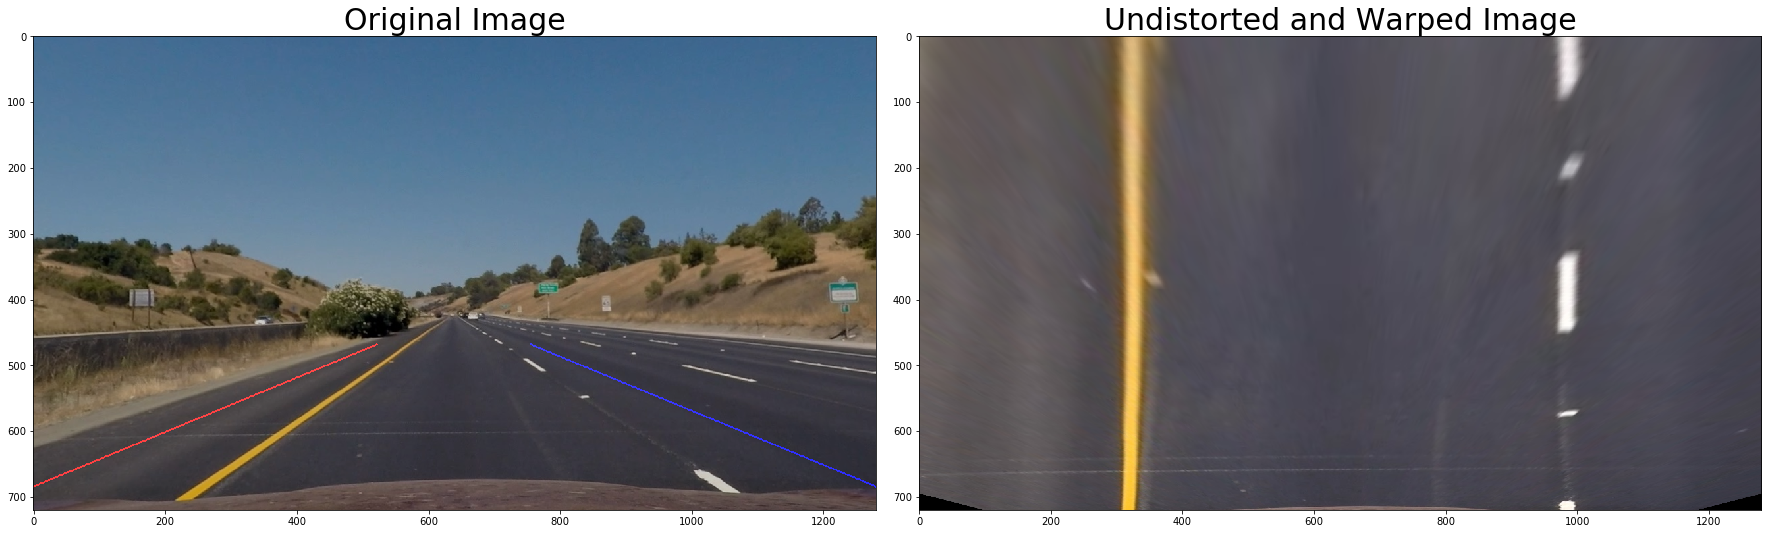

In [15]:
#correct for camera distortion
seeTopDown = undistort(cv2.imread('test_images/straight_lines1.jpg'))
#save the undistorted image
cv2.imwrite('process_steps_pictures/undistorted.jpg',seeTopDown)
#get top-down view of lane lines
seeTopDown = perspectiveTrans(seeTopDown)
#save top-down view image
cv2.imwrite('process_steps_pictures/perspective_transform.jpg',seeTopDown)
seeTopDown = cv2.cvtColor(seeTopDown, cv2.COLOR_BGR2RGB)
#display images inline for convenience
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(seeArea)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(seeTopDown)
ax2.set_title('Undistorted and Warped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

This cell displays two more steps of the process:
- Converting to a binary image showing just the lane lines
- Using a histogram method to estimate and draw a polynomial representing the lane lines

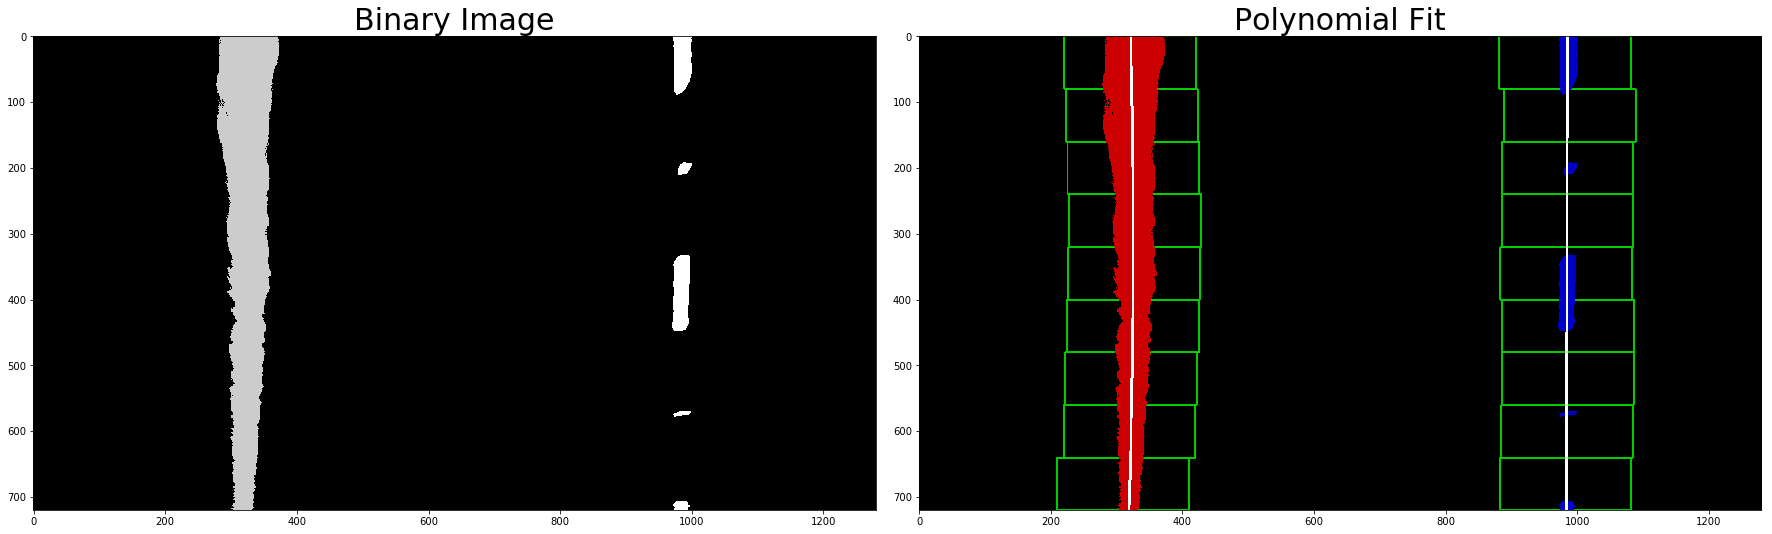

In [16]:
ftype = 'Image'
#correct for camera distortion
flatLanes = undistort(cv2.imread('test_images/straight_lines1.jpg'))
#get top-down view of lane lines
flatLanes = perspectiveTrans(flatLanes)
#get binary image of lane lines
flatLanes = pull_Yellow_White(flatLanes)
#save binary image
cv2.imwrite('process_steps_pictures/binary_image.jpg',flatLanes)
#fit a polynomial of best fit to each lane line, highlighting the pixels used for each, show histogram windows
polyLines, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(flatLanes)
#draw those polynomial equations on the image
justLines = np.zeros_like(polyLines)
for pnt in range(0,ploty.size):
    justLines[int(ploty[pnt]),(int(left_fitx[pnt])-2) : (int(left_fitx[pnt])+2)]=[255,255,255]
    justLines[int(ploty[pnt]),(int(right_fitx[pnt])-2) : (int(right_fitx[pnt])+2)]=[255,255,255]
polyLines = weighted_img(justLines,polyLines)
#save the image
cv2.imwrite('process_steps_pictures/polynomial_fit.jpg',polyLines)
#display images inline for convenience
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
flatLanes = cv2.cvtColor(flatLanes,cv2.COLOR_BGR2RGB)
ax1.imshow(flatLanes)
ax1.set_title('Binary Image', fontsize=30)
ax2.imshow(polyLines)
ax2.set_title('Polynomial Fit', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

This cell calculates the radius of curvature for each lane line at a point right in front of the car, and also determines the position of the car relative to the center of the lane where left of center is a negative value and right of center is a positive value.  An image with curved lane lines is used in this example.

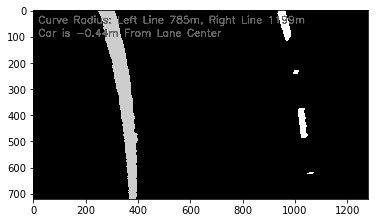

In [17]:
ftype = 'Image'
#correct for camera distortion
flatLanes = undistort(cv2.imread('test_images/test2.jpg'))
#get top-down view of lane lines
flatLanes = perspectiveTrans(flatLanes)
#get binary image of lane lines
flatLanes = pull_Yellow_White(flatLanes)
#fit a polynomial of best fit to each lane line, scaled to meters
left_fit_scaled, right_fit_scaled = fit_polynomial_scaled(flatLanes)

# Define y-value where we want radius of curvature. The maximum y-value corresponds to the bottom of the image
y_eval = np.max(ploty)  
#Implement the calculation of R_curve (radius of curvature)
left_curverad = ((1+(2*left_fit_scaled[0]*y_eval*ym_per_pix+left_fit_scaled[1])**2)**(3/2))/np.absolute(2*left_fit_scaled[0])
right_curverad = ((1+(2*right_fit_scaled[0]*y_eval*ym_per_pix+right_fit_scaled[1])**2)**(3/2))/np.absolute(2*right_fit_scaled[0])

xCenterOfCar = img_size[0]/2*xm_per_pix #assume camera is mounted at the centerline of the car
xLeftLane = left_fit_scaled[0]*(y_eval*ym_per_pix)**2 + left_fit_scaled[1]*y_eval*ym_per_pix + left_fit_scaled[2]
xRightLane = right_fit_scaled[0]*(y_eval*ym_per_pix)**2 + right_fit_scaled[1]*y_eval*ym_per_pix + right_fit_scaled[2]
xCenterOfLane = (xRightLane - xLeftLane)/2 + xLeftLane
laneOffset = xCenterOfCar - xCenterOfLane

curveText = 'Curve Radius: Left Line {:.0f}m, Right Line {:.0f}m'.format(left_curverad,right_curverad)
cv2.putText(flatLanes,curveText,(20,50),cv2.FONT_HERSHEY_SIMPLEX,1.3,[100,50,0],3,cv2.LINE_AA)
offsetText = 'Car is {:.2f}m From Lane Center'.format(laneOffset)
cv2.putText(flatLanes,offsetText,(20,100),cv2.FONT_HERSHEY_SIMPLEX,1.3,[100,50,0],3,cv2.LINE_AA)
cv2.imwrite('process_steps_pictures/curve_and_offset.jpg',flatLanes)
flatLanes = cv2.cvtColor(flatLanes,cv2.COLOR_BGR2RGB)
plt.imshow(flatLanes)
plt.show()

This cell performes all the above processes and then does the inverse of the perspective transformation to plot the lane lines and interior shape of the lane back onto the original image.

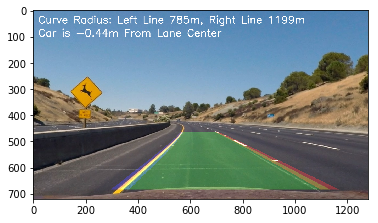

In [18]:
ftype = 'Image'
#correct for camera distortion
undist = undistort(cv2.imread('test_images/test2.jpg'))
#get top-down view of lane lines
flatLanes = perspectiveTrans(undist)
#get binary image of lane lines
flatLanes = pull_Yellow_White(flatLanes)
#fit a polynomial of best fit to each lane line, highlighting the pixels used for each, show histogram windows
polyLines, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(flatLanes)
#draw those polynomial equations on the image
justLines = np.zeros_like(polyLines)
for pnt in range(0,ploty.size):
    justLines[int(ploty[pnt]),(int(left_fitx[pnt])-30) : (int(left_fitx[pnt])+30)]=[255,0,0]
    justLines[int(ploty[pnt]),(int(right_fitx[pnt])-30) : (int(right_fitx[pnt])+30)]=[0,0,255]

# Create an image to draw the lines on
warp_zero = np.zeros_like(flatLanes).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
color_warp = weighted_img(justLines,color_warp)

#create an inverse of the perspective transform matrix
Minv = np.linalg.inv(M)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[0], img_size[1])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

#fit a polynomial of best fit to each lane line, scaled to meters
left_fit_scaled, right_fit_scaled = fit_polynomial_scaled(flatLanes)
# Define y-value where we want radius of curvature. The maximum y-value corresponds to the bottom of the image
y_eval = np.max(ploty)  
#Implement the calculation of R_curve (radius of curvature)
left_curverad = ((1+(2*left_fit_scaled[0]*y_eval*ym_per_pix+left_fit_scaled[1])**2)**(3/2))/np.absolute(2*left_fit_scaled[0])
right_curverad = ((1+(2*right_fit_scaled[0]*y_eval*ym_per_pix+right_fit_scaled[1])**2)**(3/2))/np.absolute(2*right_fit_scaled[0])
#calculate the offset from center of lane
xCenterOfCar = img_size[0]/2*xm_per_pix #assume camera is mounted at the centerline of the car
xLeftLane = left_fit_scaled[0]*(y_eval*ym_per_pix)**2 + left_fit_scaled[1]*y_eval*ym_per_pix + left_fit_scaled[2]
xRightLane = right_fit_scaled[0]*(y_eval*ym_per_pix)**2 + right_fit_scaled[1]*y_eval*ym_per_pix + right_fit_scaled[2]
xCenterOfLane = (xRightLane - xLeftLane)/2 + xLeftLane
laneOffset = xCenterOfCar - xCenterOfLane
#display the curvature and offset on the image
curveText = 'Curve Radius: Left Line {:.0f}m, Right Line {:.0f}m'.format(left_curverad,right_curverad)
cv2.putText(result,curveText,(20,50),cv2.FONT_HERSHEY_SIMPLEX,1.3,[255,255,255],2,cv2.LINE_AA)
offsetText = 'Car is {:.2f}m From Lane Center'.format(laneOffset)
cv2.putText(result,offsetText,(20,100),cv2.FONT_HERSHEY_SIMPLEX,1.3,[255,255,255],2,cv2.LINE_AA)
result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
plt.imshow(result)


### Find Lanes on Images
This cell iterates through all the images in the `test_images/` directory, finds the lane lines, and saves the result in the `test_images_output/` directory

In [19]:
for im in os.listdir("test_images/"): #iterate through each file name in the subdirectory
    filename = 'test_images/'+ im     #add the subdirectory to the file name
    image = cv2.imread(filename)  #use the path/filename to read the image ##alternate use image = mpimg.imread(filename)
    global ftype
    ftype = 'Image'
    #correct for camera distortion
    undist = undistort(image)
    #get top-down view of lane lines
    perspTrans = perspectiveTrans(undist)
    #get binary image of lane lines
    binaryPersp = pull_Yellow_White(perspTrans)
    #fit a polynomial of best fit to each lane line
    polyLines, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(binaryPersp)
    #draw those polynomial equations on the image
    justLines = np.zeros_like(perspTrans)
    for pnt in range(0,ploty.size):
        justLines[int(ploty[pnt]),(int(left_fitx[pnt])-20) : (int(left_fitx[pnt])+20)]=[255,0,0]
        justLines[int(ploty[pnt]),(int(right_fitx[pnt])-20) : (int(right_fitx[pnt])+20)]=[0,0,255]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binaryPersp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    color_warp = weighted_img(justLines,color_warp)
    #create an inverse of the perspective transform matrix
    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[0], img_size[1])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #fit a polynomial of best fit to each lane line, scaled to meters
    left_fit_scaled, right_fit_scaled = fit_polynomial_scaled(binaryPersp)
    # Define y-value where we want radius of curvature. The maximum y-value corresponds to the bottom of the image
    y_eval = np.max(ploty)  
    #Implement the calculation of R_curve (radius of curvature)
    left_curverad = ((1+(2*left_fit_scaled[0]*y_eval*ym_per_pix+left_fit_scaled[1])**2)**(3/2))/np.absolute(2*left_fit_scaled[0])
    right_curverad = ((1+(2*right_fit_scaled[0]*y_eval*ym_per_pix+right_fit_scaled[1])**2)**(3/2))/np.absolute(2*right_fit_scaled[0])
    #calculate the offset from center of lane
    xCenterOfCar = img_size[0]/2*xm_per_pix #assume camera is mounted at the centerline of the car
    xLeftLane = left_fit_scaled[0]*(y_eval*ym_per_pix)**2 + left_fit_scaled[1]*y_eval*ym_per_pix + left_fit_scaled[2]
    xRightLane = right_fit_scaled[0]*(y_eval*ym_per_pix)**2 + right_fit_scaled[1]*y_eval*ym_per_pix + right_fit_scaled[2]
    xCenterOfLane = (xRightLane - xLeftLane)/2 + xLeftLane
    laneOffset = xCenterOfCar - xCenterOfLane
    #display the curvature and offset on the image
    curveText = 'Curve Radius: Left Line {:.0f}m, Right Line {:.0f}m'.format(left_curverad,right_curverad)
    cv2.putText(result,curveText,(20,50),cv2.FONT_HERSHEY_SIMPLEX,1.3,[255,255,255],2,cv2.LINE_AA)
    offsetText = 'Car is {:.2f}m From Lane Center'.format(laneOffset)
    cv2.putText(result,offsetText,(20,100),cv2.FONT_HERSHEY_SIMPLEX,1.3,[255,255,255],2,cv2.LINE_AA)
    
    #save the images
    saveName = 'test_images_output/highlighted_'+im
    cv2.imwrite(saveName,result)
    
    

### Find Lanes on Videos
***

In [20]:
#This cell processes the project assignment video
frameNum=0
ftype = 'Video'
leftStats = Line()
rightStats = Line()
video_output = 'test_videos_output/lanes_project_video.mp4'
clip1 = VideoFileClip("test_videos/project_video.mp4")#.subclip(35,45) ##add this for partial video
video_clip = clip1.fl_image(process_image) 
%time video_clip.write_videofile(video_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/lanes_project_video.mp4.
Moviepy - Writing video test_videos_output/lanes_project_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/lanes_project_video.mp4
CPU times: user 16min 11s, sys: 4min 16s, total: 20min 28s
Wall time: 12min 57s


In [23]:
#This cell processes the optional challenge video
frameNum=0
ftype = 'Video'
leftStats = Line()
rightStats = Line()
video_output = 'test_videos_output/lanes_challenge_video.mp4'
clip1 = VideoFileClip("test_videos/challenge_video.mp4")#.subclip(1,6) ##add this for partial video
video_clip = clip1.fl_image(process_image) 
%time video_clip.write_videofile(video_output, audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/lanes_challenge_video.mp4.
Moviepy - Writing video test_videos_output/lanes_challenge_video.mp4



t:  28%|██▊       | 134/485 [01:10<02:04,  2.81it/s, now=None]

The function failed to find valid right line coordinates, making substitution


t:  28%|██▊       | 135/485 [01:10<01:51,  3.15it/s, now=None]

The function failed to find valid left line coordinates, making substitution
The function failed to find valid right line coordinates, making substitution


t:  28%|██▊       | 136/485 [01:10<01:47,  3.26it/s, now=None]

The function failed to find valid left line coordinates, making substitution
The function failed to find valid right line coordinates, making substitution


t:  28%|██▊       | 137/485 [01:11<01:45,  3.29it/s, now=None]

The function failed to find valid left line coordinates, making substitution
The function failed to find valid right line coordinates, making substitution


t:  28%|██▊       | 138/485 [01:11<01:37,  3.55it/s, now=None]

The function failed to find valid left line coordinates, making substitution


t:  29%|██▊       | 139/485 [01:11<01:37,  3.55it/s, now=None]

The function failed to find valid left line coordinates, making substitution
The function failed to find valid left line coordinates, making substitution


t:  29%|██▉       | 140/485 [01:12<01:59,  2.89it/s, now=None]

The function failed to find valid left line coordinates, making substitution


Moviepy - Done !
Moviepy - video ready test_videos_output/lanes_challenge_video.mp4
CPU times: user 5min 54s, sys: 1min 44s, total: 7min 39s
Wall time: 4min 37s
